# Equity portfolio optimization
- - -

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd

from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

import yfinance as yf

import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci

import statsmodels.api as sm

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import plotly.figure_factory as ff

import functions as fun

import os

In [3]:
def statistics(weights):
    
    weights = np.array(weights) 
    pret = np.sum(rets_mean * weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
    
    return np.array([pret, pvol, pret / pvol])

def min_func_port(w):
    return statistics(w)[1]

def port_opt(rets_mean, sigma, noa, Rf):
   
    weights = np.zeros((2000,noa))
    for i in range(len(weights)):
        weights[i] = fun.rand_weights(noa)
    
    ex_weights = np.zeros((10000,noa))
    for i in range(len(ex_weights)):
        ex_weights[i] = fun.extreme_weights(noa)
    
    new_weights = np.concatenate((weights, ex_weights, np.identity(noa)))

    pret= fun.portf_mean(new_weights, rets_mean)
    pvol = np.sqrt(fun.portf_var(new_weights, sigma))
    
    trets = np.linspace(0, max(pret))
    tvols = []
    
    for tret in trets:
        bnds = tuple((0, 1) for x in range(noa))
        cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret}, 
                {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
        res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',  
                           bounds=bnds, constraints=cons)
        tvols.append(res['fun'])
       
    tvols = np.array(tvols)
    
    ind = np.argmin(tvols)
    evols = tvols[ind:]
    erets = trets[ind:]

    tck = sci.splrep(evols, erets)
    
    Sr = []
    for sig, mu in zip(evols, sci.splev(evols, tck, der = 0)):
         Sr.append((mu - Rf)/sig)
        
    sigma_T = np.linspace(0.0, max(evols))
    E_T = Rf + max(Sr)*sigma_T

    TP = np.argmax(Sr)
    
    con = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - erets[TP]}, 
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    solve = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',bounds=bnds, constraints=con)
    
    keys = rets_mean.index
    values = solve['x'].round(6)
    opt = {keys[i]: values[i] for i in range(len(keys))} 

    plt.figure(figsize=(22,9))

    # random portfolio composition
    plt.scatter(pvol, pret, marker= 'o', lw = 0.1, c = pret/pvol, edgecolors='w')

    # efficient frontier
    plt.plot(evols, erets, 'deeppink', lw=4, label='Efficient frontier')

    # capital market line
    plt.plot(sigma_T, E_T, lw = 3, label= 'Capital Market Line')

    # tangency portfolio
    plt.plot(evols[TP], erets[TP], 'y*', markersize=25.0, label='Tangency portfolio')
    
    plt.grid(True)
    plt.axhline(0, color='k', ls='--', lw=2.0)
    plt.axvline(0, color='k', ls='--', lw=2.0)
    plt.xlabel('expected volatility', fontsize = 15)
    plt.ylabel('expected return', fontsize = 15)
    plt.colorbar(label='Sharpe ratio')
    plt.legend(fontsize=12, loc = 'best')
    plt.title('Capital market line and tangency portfolio', fontsize = 15)
    
    exp_rets = erets[TP]
    exp_vol = evols[TP]

    
    return opt, exp_rets, exp_vol

## Data

In [32]:
tickers = ['AAPL', 'MELI', 'TSLA', 'AMZN', 'TS', 'KO', 'PBR', 'GOLD', 'XOM', 
           'WMT', 'MSFT', 'MCD', 'GOOG', 'DIS', 'FB', 'C', 'NVDA', 'BAC']

data = pd.DataFrame(columns = tickers)

In [33]:
for ticker in tickers:
    data[ticker] = yf.download(ticker, start='2011-01-01')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [34]:
fig = px.line(data)
fig.show()

In [35]:
def total_return(prices):
    return prices.iloc[-1] / prices.iloc[0] - 1

In [36]:
year_returns = data.groupby(data.index.year).apply(total_return)*100

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 11 Text major ticklabel objects>)

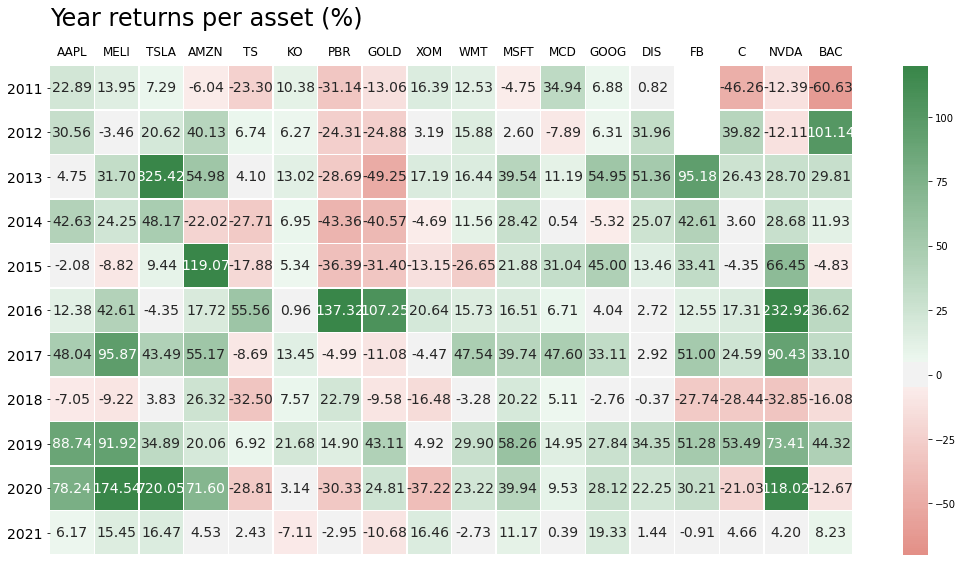

In [37]:
cmap = sns.diverging_palette(h_neg=15, h_pos=133, as_cmap=True)
fig5 = plt.figure(figsize=(18,9))
sns.heatmap(year_returns, annot = True, linewidths=.5, cmap=cmap, fmt='.2f', vmin=-70, vmax=120, center=0.0, annot_kws=dict(fontsize=14))
plt.title('Year returns per asset (%)', fontsize = 24, loc = 'left', pad=20)
plt.ylabel('', fontsize = 15)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, labeltop=True)
plt.xticks(rotation=0, fontsize = 12)
plt.yticks(rotation=0, fontsize = 14)

## Static optimization

In [38]:
rets = data.pct_change()
rets.dropna(inplace = True)
data['Tbill'] = (yf.download('^IRX', start = '2011-01-01')['Adj Close'])/100
data.fillna(method = 'ffill')

[*********************100%***********************]  1 of 1 completed


AAPL         MELI        TSLA         AMZN         TS  \
Date                                                                      
2011-01-03   10.153707    67.936424    5.324000   184.220001  38.961239   
2011-01-04   10.206698    68.450005    5.334000   185.009995  38.376549   
2011-01-05   10.290187    69.874420    5.366000   187.419998  38.179012   
2011-01-06   10.281872    72.229103    5.576000   185.860001  37.412586   
2011-01-07   10.355501    71.560463    5.648000   185.490005  37.286167   
...                ...          ...         ...          ...        ...   
2021-01-29  131.960007  1779.510010  793.530029  3206.199951  15.460000   
2021-02-01  134.139999  1896.790039  839.809998  3342.879883  15.790000   
2021-02-02  134.990005  1909.989990  872.789978  3380.000000  16.049999   
2021-02-03  133.940002  1870.520020  854.690002  3312.530029  16.260000   
2021-02-04  137.389999  1893.349976  849.989990  3331.000000  16.410000   

                   KO        PBR       GOLD        XOM         WMT  \
Date                                                                 
2011-01-03  23.901567  32.661407  46.316170  51.319824   42.831623   
2011-01-04  23.406820  32.389889  45.505936  51.560768   42.996479   
2011-01-05  23.267569  32.565071  43.947086  51.423077   42.713863   
2011-01-06  23.098988  32.205952  43.383442  51.753510   42.360603   
2011-01-07  23.058666  31.724224  43.242523  52.035751   42.454815   
...               ...        ...        ...        ...         ...   
2021-01-29  48.150002  10.050000  22.370001  44.840000  140.490005   
2021-02-01  48.480000  10.280000  22.540001  44.919998  139.270004   
2021-02-02  48.959999  10.830000  22.340000  45.630001  140.770004   
2021-02-03  48.770000  10.950000  22.340000  47.419998  141.199997   
2021-02-04  49.009998  10.860000  21.990000  48.330002  142.529999   

                  MSFT         MCD         GOOG         DIS          FB  \
Date                                                                      
2011-01-03   22.246056   57.279961   301.046600   33.302662         NaN   
2011-01-04   22.333513   55.567543   299.935760   34.332928         NaN   
2011-01-05   22.261955   55.829273   303.397797   35.187054         NaN   
2011-01-06   22.913908   55.492764   305.604523   34.914082         NaN   
2011-01-07   22.738998   55.612411   307.069031   34.737968         NaN   
...                ...         ...          ...         ...         ...   
2021-01-29  231.960007  207.839996  1835.739990  168.169998  258.329987   
2021-02-01  239.649994  207.929993  1901.349976  170.970001  262.010010   
2021-02-02  239.509995  209.759995  1927.510010  176.960007  267.079987   
2021-02-03  243.000000  208.710007  2070.070068  176.429993  266.649994   
2021-02-04  242.009995  211.029999  2062.370117  180.229996  266.489990   

                    C        NVDA        BAC    Tbill  
Date                                                   
2011-01-03  43.098766   14.545111  12.455543  0.00120  
2011-01-04  43.098766   14.499138  12.499434  0.00135  
2011-01-05  43.714458   15.611631  12.727651  0.00135  
2011-01-06  43.538563   17.772249  12.674986  0.00140  
2011-01-07  43.450588   18.268728  12.508212  0.00135  
...               ...         ...        ...      ...  
2021-01-29  57.990002  519.590027  29.650000  0.00048  
2021-02-01  58.430000  529.479980  29.959999  0.00048  
2021-02-02  59.580002  542.270020  31.030001  0.00050  
2021-02-03  61.099998  541.219971  31.580000  0.00040  
2021-02-04  62.410000  546.570007  32.500000  0.00030  

[2540 rows x 19 columns]

In [39]:
noa = len(rets.columns)
rets_mean= (1 + rets.mean())**252 -1
sigma = (rets).cov() * 252
Rf = data['Tbill'].mean()

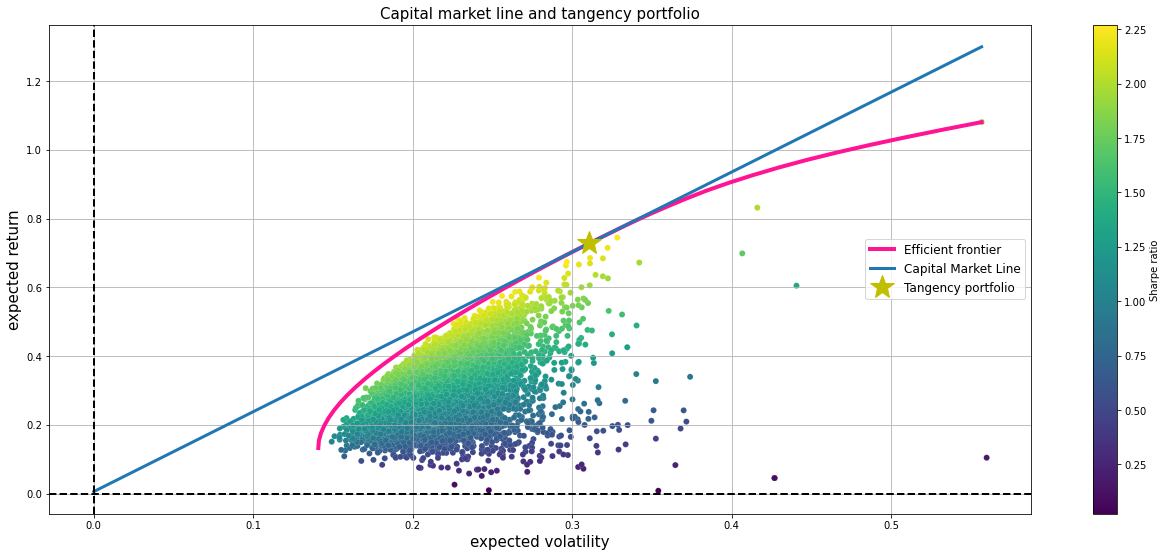

In [40]:
opt, exp_rets, exp_vol = port_opt(rets_mean, sigma, noa, Rf)

In [41]:
print('The optimal weights are:')
opt

The optimal weights are:


{'AAPL': 0.0,
 'MELI': 0.124376,
 'TSLA': 0.330289,
 'AMZN': 0.162215,
 'TS': 0.0,
 'KO': 0.0,
 'PBR': 0.0,
 'GOLD': 0.0,
 'XOM': 0.0,
 'WMT': 0.077463,
 'MSFT': 0.0,
 'MCD': 0.0,
 'GOOG': 0.0,
 'DIS': 0.0,
 'FB': 0.0,
 'C': 0.0,
 'NVDA': 0.305657,
 'BAC': 0.0}

# Ex-post performance of the mean-variance optimization
_______

## Annual:

We use information of 252 days before to estimate mean and variance. We optimize and get the weights on each risky asset. We then invest those weights for the following 252 days and compare the expost results with the expected ones.
___

### Rolling window moments

In [19]:
rets_rw_mean = np.round(((1 + rets.rolling(252).mean())**252) -1, 4).dropna()
rets_rw_std = np.round(rets.rolling(252).std() * np.sqrt(252),4).dropna()
rets_rw_cov = np.round(rets.rolling(252).cov() * 252,4).dropna()

### Select a day for the optimization

In [20]:
year = int(input('Year (from 2012 to one year ago): '))
month = int(input('Month: '))
day = int(input('Day: '))
date= datetime(year, month, day)

try:
    t = rets_rw_mean.index.get_loc(date)
except KeyError:
    print('The selected is a non-business day. Try again')

Year (from 2012 to one year ago): 2019
Month: 1
Day: 3


In [21]:
noa = len(rets.columns)
rets_mean=rets_rw_mean.iloc[t]
sigma = rets_rw_cov.loc[rets_rw_mean.index[t]]
Rf = data['Tbill'][rets_rw_mean.index[t]]

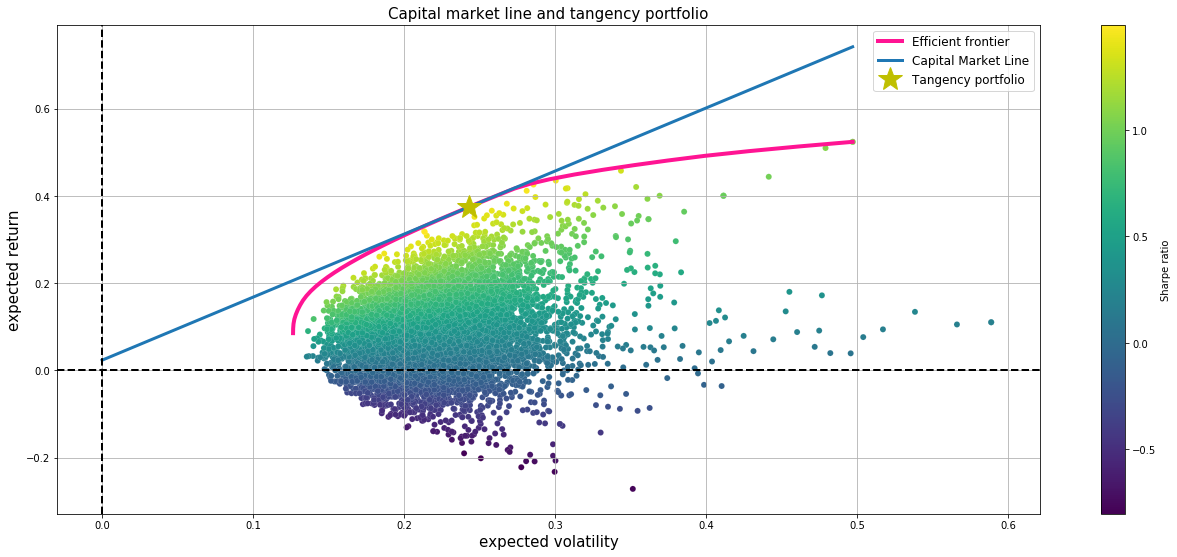

In [22]:
opt, exp_rets, exp_vol = port_opt(rets_mean, sigma, noa, Rf)
opt_weights = list(opt.values())

In [23]:
print('The optimal weights on '+ str(date.date())+ ' are:')
opt

The optimal weights on 2019-01-03 are:


{'AAPL': 0.0,
 'MELI': 0.0,
 'TSLA': 0.0,
 'AMZN': 0.322059,
 'TS': 0.0,
 'KO': 0.116269,
 'PBR': 0.237513,
 'GOLD': 0.324158,
 'XOM': 0.0,
 'WMT': 0.0,
 'MSFT': 0.0,
 'MCD': 0.0,
 'GOOG': 0.0,
 'DIS': 0.0}

### Ex-post performance

In [24]:
print(' - The expected return of the optimization is ' + str(exp_rets.round(4)))
print(' - The expected volatility of the optimization is ' + str(exp_vol.round(4)))
print(' - The expected Sharpe ratio of the optimization is ' + str(((exp_rets - Rf)/exp_vol).round(4)))

 - The expected return of the optimization is 0.3743
 - The expected volatility of the optimization is 0.2427
 - The expected Sharpe ratio of the optimization is 1.4452


In [27]:
ret_expost = np.dot(opt_weights, ((rets[rets_rw_mean.index[t]:rets_rw_mean.index[t+251]] +1).rolling(252).apply(np.prod)-1).dropna().T)[0]
vol_expost= np.sqrt(np.dot(opt_weights, np.dot(rets_rw_cov.loc[rets_rw_mean.index[251 + t]], opt_weights)))

In [28]:
print(' - The ex-post return of the optimization is ' + str(ret_expost.round(4))) 
print(' - The ex-post volatility of the optimization is ' + str(vol_expost.round(4)))
print(' - The ex-post Sharpe ratio of the optimization is ' + str(((ret_expost - Rf)/vol_expost).round(4)))

 - The ex-post return of the optimization is 0.2811
 - The ex-post volatility of the optimization is 0.1552
 - The ex-post Sharpe ratio of the optimization is 1.6591


## Monthly
____

We use information of 252 days before to estimate mean and variance. We optimize and get the weights on each risky asset. We then invest those weights for the following 21 days and compare the expost results with the expected ones.

### Rolling windows moments

In [145]:
rets_rw_mean_m = np.round(((1 + rets.rolling(21).mean())**21) -1 ,4).dropna()
rets_rw_std_m = np.round(rets.rolling(21).std() * np.sqrt(21),4).dropna()
rets_rw_cov_m = np.round(rets.rolling(21).cov() * np.sqrt(21),4).dropna()

### Select a day for the optimization

In [146]:
year = int(input('Year (starting in 2012): '))
month = int(input('Month: '))
day = int(input('Day: '))
date= datetime(year, month, day)

try:
    t = rets_rw_mean.index.get_loc(date)
except KeyError:
    print('Ups! You chose a non-business day. Try again')

Year (starting in 2012): 2020
Month: 9
Day: 10


In [147]:
noa = len(rets.columns)
rets_mean=rets_rw_mean.iloc[t]
sigma = rets_rw_cov.loc[rets_rw_mean_m.index[t]]
Rf = data['Tbill'][rets_rw_mean.index[t]]

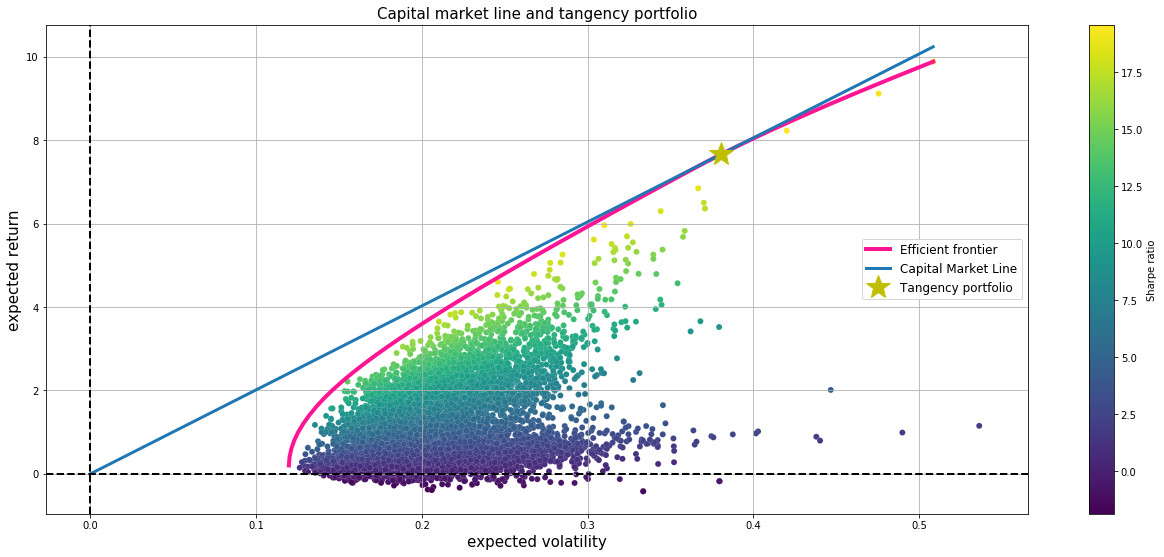

In [148]:
opt, exp_rets, exp_vol = port_opt(rets_mean, sigma, noa, Rf)
opt_weights = list(opt.values())

In [149]:
print('The optimal weights on '+ str(date.date())+ ' are:')
opt

The optimal weights on 2020-09-10 are:


{'AAPL': 0.0,
 'MELI': 0.0,
 'TSLA': 0.751067,
 'AMZN': 0.0,
 'TS': 0.0,
 'KO': 0.0,
 'PBR': 0.0,
 'GOLD': 0.248933,
 'XOM': 0.0,
 'WMT': 0.0,
 'MSFT': 0.0,
 'MCD': 0.0,
 'GOOG': 0.0,
 'DIS': 0.0}

### Ex-post performance

In [151]:
print(' - The expected monthly return of the optimization is ' + str((exp_rets*21/252).round(4)))
print(' - The expected monthly volatility of the optimization is ' + str((exp_vol*np.sqrt(21/252)).round(4)))
print(' - The expected Sharpe ratio of the optimization is ' + str(((exp_rets - Rf)/exp_vol).round(4)))

 - The expected return of the optimization is 0.6385
 - The expected volatility of the optimization is 0.1099
 - The expected Sharpe ratio of the optimization is 20.1306


In [153]:
ret_expost = np.dot(opt_weights, ((rets[rets_rw_mean.index[t]:rets_rw_mean.index[t+20]] +1).apply(np.prod)-1))
vol_expost= np.sqrt(np.dot(opt_weights, np.dot(rets_rw_cov_m.loc[rets_rw_mean_m.index[20 + t]], opt_weights)))

In [154]:
print(' - The ex-post monthly return of the optimization is ' + str(ret_expost.round(4))) 
print(' - The ex-post monthly volatility of the optimization is ' + str(vol_expost.round(4)))
print(' - The ex-post Sharpe ratio of the optimization is ' + str(((ret_expost - Rf)/vol_expost).round(4)))

 - The ex-post return of the optimization is 0.0962
 - The ex-post volatility of the optimization is 0.0769
 - The ex-post Sharpe ratio of the optimization is 1.2374


## Dynamic weights

In [129]:
dyn_weights = pd.DataFrame(columns = rets.columns)
dyn_exp_rets = []
dyn_exp_vol = []

weights = np.zeros((2000,noa))
for i in range(len(weights)):
    weights[i] = fun.rand_weights(noa)
    
ex_weights = np.zeros((10000,noa))
for i in range(len(ex_weights)):
     ex_weights[i] = fun.extreme_weights(noa)
    
new_weights = np.concatenate((weights, ex_weights, np.identity(noa)))
    
t0 = rets_rw_mean.index.get_loc(datetime(2020,1,3))
T = rets_rw_mean.index.get_loc(datetime(2020,9,3))

for t in range(t0,T):
    rets_mean=rets_rw_mean.iloc[t]
    sigma = rets_rw_cov.loc[rets_rw_mean.index[t]]
    Rf = data['Tbill'][rets_rw_mean.index[t]]
    
    pret= fun.portf_mean(new_weights, rets_mean)
    pvol = np.sqrt(fun.portf_var(new_weights, sigma))
    
    trets = np.linspace(0, max(pret))
    tvols = []
    
    for tret in trets:
        bnds = tuple((0, 1) for x in range(noa))
        cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret}, 
                {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
        res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',  
                           bounds=bnds, constraints=cons)
        tvols.append(res['fun'])
       
    tvols = np.array(tvols)
    
    ind = np.argmin(tvols)
    evols = tvols[ind:]
    erets = trets[ind:]

    tck = sci.splrep(evols, erets)
    
    Sr = []
    for sig, mu in zip(evols, sci.splev(evols, tck, der = 0)):
         Sr.append((mu - Rf)/sig)
        
    sigma_T = np.linspace(0.0, max(evols))
    E_T = Rf + max(Sr)*sigma_T

    TP = np.argmax(Sr)
    
    con = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - erets[TP]}, 
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    solve = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',bounds=bnds, constraints=con)
    
    keys = rets_mean.index
    values = solve['x'].round(6)
                   
    weights = values.tolist()
    exp_rets = erets[TP]
    exp_vol = evols[TP]
                       
    dyn_weights.loc[t]= weights
    dyn_exp_rets.append(exp_rets)
    dyn_exp_vol.append(exp_vol)

In [132]:
dyn_weights.index = rets_rw_mean.index[t0: T]

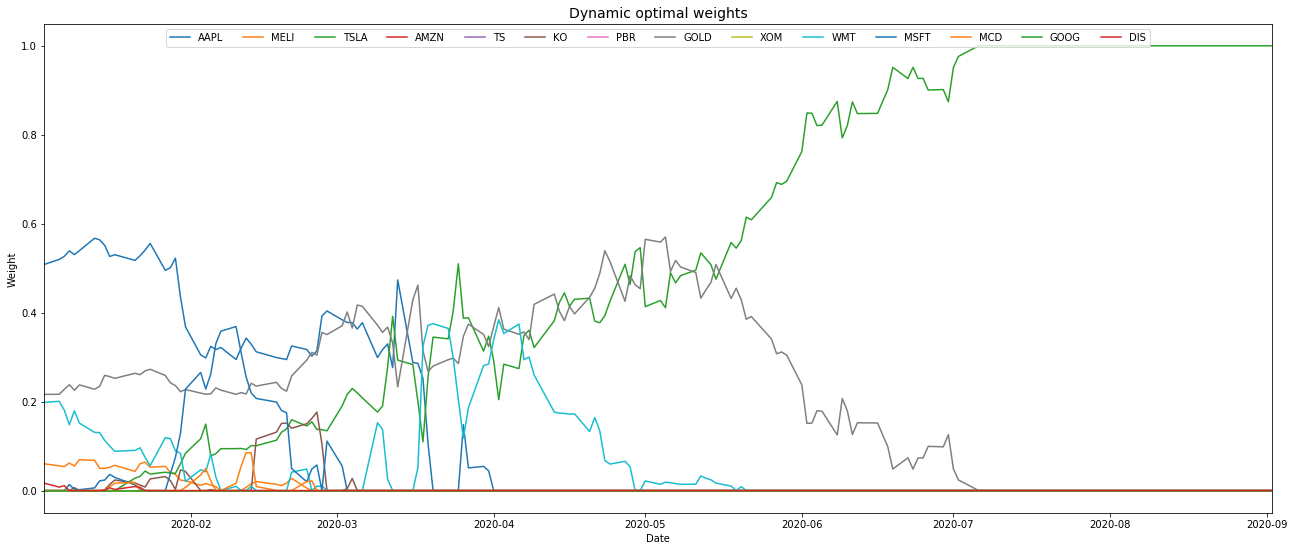

In [133]:
fig = plt.figure(figsize = (22,9))
plt.plot(dyn_weights)
plt.title('Dynamic optimal weights', fontsize = 14)
plt.xlabel('Date')
plt.ylabel('Weight')
plt.autoscale(axis = 'x', tight = True)
plt.legend(dyn_weights.columns, ncol=len(dyn_weights.columns), loc = 'upper center')

In [135]:
Exp_moments = pd.DataFrame(columns = ['Expected returns', 'Expected volatility'], index = dyn_weights.index)
Exp_moments['Expected returns'] = dyn_exp_rets
Exp_moments['Expected volatility'] = dyn_exp_vol

In [136]:
expost_rets = pd.DataFrame(columns = rets.columns)

for t in range(t0,T):
    epret = (rets[rets_rw_mean.index[t]: rets_rw_mean.index[21 + t]]+1).apply(np.prod)-1
    expost_rets.loc[t-t0]= epret    

obs_rets = np.diag(dyn_weights.dot(expost_rets.T))    

In [139]:
obs_vol = pd.Series(dtype = 'float64')

for t in range(t0, T):
    vol = rets_rw_cov_m.loc[rets_rw_mean.index[t+21]]
    expost_v = np.sqrt(dyn_weights.loc[rets_rw_mean.index[t]].dot(vol).dot(dyn_weights.loc[rets_rw_mean.index[t]]))
    obs_vol.loc[t]= expost_v

In [140]:
Obs_moments = pd.DataFrame(columns = ['Ex-post returns', 'Ex-post volatility'], index = dyn_weights.index)
Obs_moments['Ex-post returns'] = obs_rets
Obs_moments['Ex-post volatility'] = obs_vol.values

In [144]:
#Guardo todo para no tener que volver a correr tantas optimizaciones

dyn_weights.to_excel('Dyn_weights2.xls')
Exp_moments.to_excel('Expected returns2.xls')
Obs_moments.to_excel('Ex post returns2.xls')

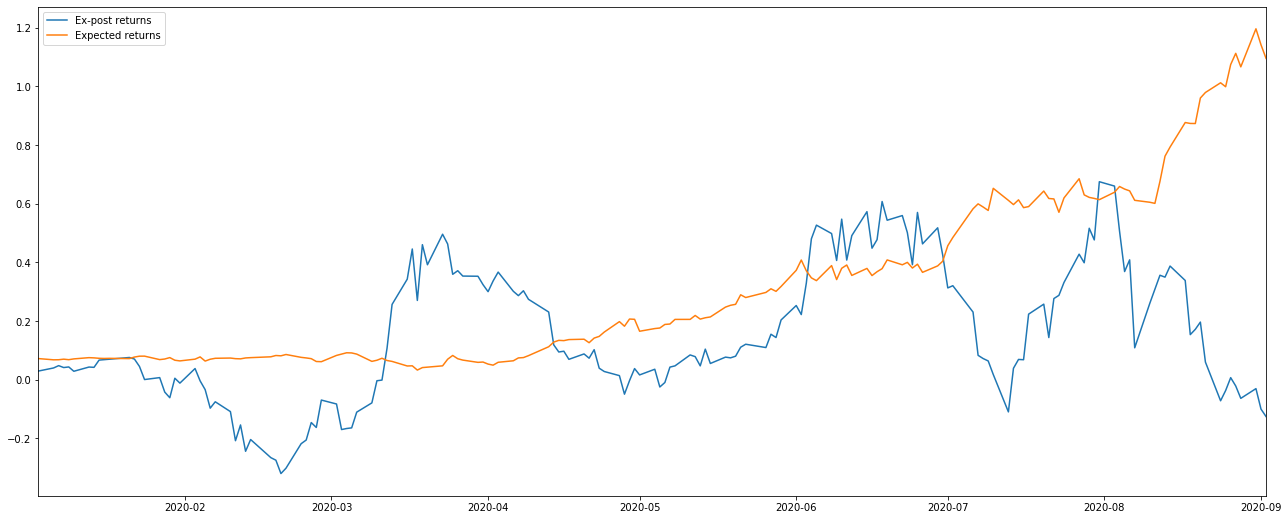

In [141]:
fig = plt.figure(figsize = (22,9))
plt.plot(Obs_moments['Ex-post returns'], label = 'Ex-post returns')
plt.plot(Exp_moments['Expected returns']*21/252, label = 'Expected returns')
plt.legend(loc='best')
plt.autoscale(tight =True, axis = 'x')

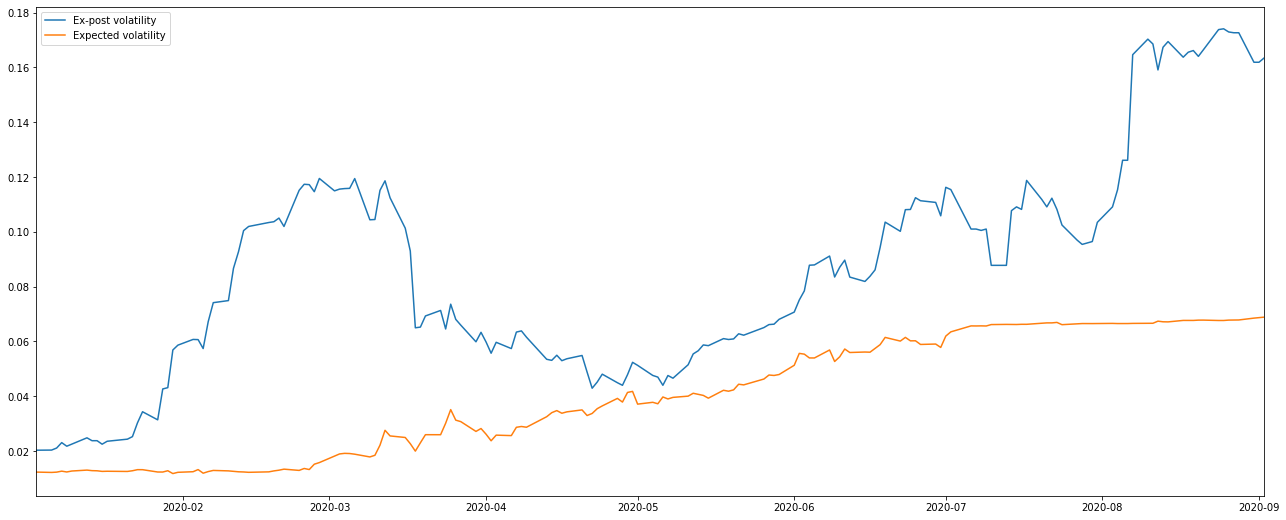

In [142]:
fig = plt.figure(figsize = (22,9))
plt.plot(Obs_moments['Ex-post volatility'], label = 'Ex-post volatility')
plt.plot(Exp_moments['Expected volatility']*21/252, label = 'Expected volatility')
plt.legend(loc='best')
plt.autoscale(tight =True, axis = 'x')

In [150]:
dyn_weights

AAPL      MELI  TSLA  AMZN   TS        KO  PBR      GOLD  XOM  \
Date                                                                            
2020-01-03  0.508317  0.060226   0.0   0.0  0.0  0.000000  0.0  0.216309  0.0   
2020-01-06  0.519680  0.055482   0.0   0.0  0.0  0.000000  0.0  0.216464  0.0   
2020-01-07  0.526540  0.053850   0.0   0.0  0.0  0.000000  0.0  0.227641  0.0   
2020-01-08  0.538830  0.061731   0.0   0.0  0.0  0.000000  0.0  0.237940  0.0   
2020-01-09  0.530474  0.055166   0.0   0.0  0.0  0.006533  0.0  0.225560  0.0   
...              ...       ...   ...   ...  ...       ...  ...       ...  ...   
2020-08-27  0.000000  0.000000   1.0   0.0  0.0  0.000000  0.0  0.000000  0.0   
2020-08-28  0.000000  0.000000   1.0   0.0  0.0  0.000000  0.0  0.000000  0.0   
2020-08-31  0.000000  0.000000   1.0   0.0  0.0  0.000000  0.0  0.000000  0.0   
2020-09-01  0.000000  0.000000   1.0   0.0  0.0  0.000000  0.0  0.000000  0.0   
2020-09-02  0.000000  0.000000   1.0   0.0  0.0  0.000000  0.0  0.000000  0.0   

                 WMT      MSFT  MCD  GOOG       DIS  
Date                                                 
2020-01-03  0.198428  0.000000  0.0   0.0  0.016720  
2020-01-06  0.200580  0.000000  0.0   0.0  0.007795  
2020-01-07  0.180926  0.000000  0.0   0.0  0.011043  
2020-01-08  0.148002  0.013497  0.0   0.0  0.000000  
2020-01-09  0.179334  0.002932  0.0   0.0  0.000000  
...              ...       ...  ...   ...       ...  
2020-08-27  0.000000  0.000000  0.0   0.0  0.000000  
2020-08-28  0.000000  0.000000  0.0   0.0  0.000000  
2020-08-31  0.000000  0.000000  0.0   0.0  0.000000  
2020-09-01  0.000000  0.000000  0.0   0.0  0.000000  
2020-09-02  0.000000  0.000000  0.0   0.0  0.000000  

[169 rows x 14 columns]